In [1]:
# Imports ve yardımcı fonksiyonlar
import os
import random
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

BASE_PATH = r"c:\Users\USER\Desktop\1mMovieLens\archive (3)"

def load_movielens_1m(base_path=BASE_PATH):
    # Dosya yolları
    ratings_f = "/kaggle/input/movielens-1m-dataset/ratings.dat"
    users_f   = "/kaggle/input/movielens-1m-dataset/users.dat"
    movies_f  = "/kaggle/input/movielens-1m-dataset/movies.dat"
    # ratings.dat format: UserID::MovieID::Rating::Timestamp
    ratings = pd.read_csv(ratings_f, sep='::', engine='python', names=['userId','movieId','rating','timestamp'])
    # users, movies opsiyonel yükleme (analiz için)
    try:
        users = pd.read_csv(users_f, sep='::', engine='python', names=['userId','gender','age','occupation','zip'])
    except Exception:
        users = None
    try:
        movies = pd.read_csv(movies_f, sep='::', engine='python', names=['movieId','title','genres'])
    except Exception:
        movies = None
    return ratings, users, movies

def user_stratified_train_test_split(ratings, test_size=0.2, seed=42):
    # Her kullanıcıdan en az 1 test elemanı ayırmaya çalışır (len>=2 için)
    rng = np.random.RandomState(seed)
    train_list = []
    test_list = []
    for uid, group in ratings.groupby('userId'):
        n = len(group)
        if n == 1:
            train_list.append(group)
            continue
        n_test = max(1, int(np.floor(test_size * n)))
        test_idx = rng.choice(group.index, size=n_test, replace=False)
        test_list.append(group.loc[test_idx])
        train_list.append(group.drop(test_idx))
    train = pd.concat(train_list).reset_index(drop=True)
    test = pd.concat(test_list).reset_index(drop=True)
    return train, test

def create_user_item_matrix(ratings, fillna=0):
    piv = ratings.pivot_table(index='userId', columns='movieId', values='rating')
    user_ids = piv.index.tolist()
    item_ids = piv.columns.tolist()
    mat = piv.fillna(fillna).values
    return piv, csr_matrix(mat), user_ids, item_ids

def fit_knn_on_users(sparse_matrix, n_neighbors=20, metric='cosine'):
    model = NearestNeighbors(metric=metric, algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)
    model.fit(sparse_matrix)
    return model

def predict_user_based(user_id, item_id, piv, model, user_ids, item_ids, k=20):
    # Eğer kullanıcı veya item pivot'ta yoksa NaN dönüş
    if user_id not in user_ids or item_id not in item_ids:
        return np.nan
    uidx = user_ids.index(user_id)
    i_col = item_ids.index(item_id)
    user_vector = piv.fillna(0).iloc[uidx].values.reshape(1, -1)
    distances, indices = model.kneighbors(user_vector, n_neighbors=k)
    distances = distances.flatten()
    indices = indices.flatten()
    # similarities
    sims = 1 - distances
    # komşuların item üzerindeki oyları
    neighbor_ratings = []
    weights = []
    for sim, nidx in zip(sims, indices):
        r = piv.fillna(np.nan).iloc[nidx, i_col]
        if not np.isnan(r):
            neighbor_ratings.append(r)
            weights.append(sim)
    if len(neighbor_ratings) == 0:
        # fallback: kullanıcının ortalaması veya global ortalama
        user_mean = piv.fillna(np.nan).iloc[uidx].mean()
        if np.isnan(user_mean):
            return piv.stack().mean()
        return user_mean
    weights = np.array(weights)
    if weights.sum() == 0:
        return np.mean(neighbor_ratings)
    return np.dot(weights, neighbor_ratings) / weights.sum()

# Yeni: cached tahmin fonksiyonu — kneighbors çağrısının tekrarını önlemek için ön-hesaplanmış matrisi kullanır
def predict_user_based_cached(user_id, item_id, piv_nan_array, indices_matrix, distances_matrix, user_ids, item_ids, k=20):
    # user veya item train pivot'ta yoksa NaN dön
    if user_id not in user_ids or item_id not in item_ids:
        return np.nan
    uidx = user_ids.index(user_id)
    i_col = item_ids.index(item_id)
    # ön-hesaplanmış komşu indeksleri / uzaklıklar
    neigh_idxs = indices_matrix[uidx]  # shape (k,)
    neigh_dists = distances_matrix[uidx]  # shape (k,)
    sims = 1 - neigh_dists
    neighbor_ratings = []
    weights = []
    for sim, nidx in zip(sims, neigh_idxs):
        r = piv_nan_array[nidx, i_col]
        if not np.isnan(r):
            neighbor_ratings.append(r)
            weights.append(sim)
    if len(neighbor_ratings) == 0:
        # fallback: kullanıcının ortalaması veya global ortalama
        user_row = piv_nan_array[uidx]
        user_mean = np.nanmean(user_row) if np.any(~np.isnan(user_row)) else np.nan
        if np.isnan(user_mean):
            # global mean fallback (piv.stack().mean() equivalent not available here) — caller can compute global mean if needed
            return np.nan
        return user_mean
    weights = np.array(weights)
    if weights.sum() == 0:
        return np.mean(neighbor_ratings)
    return np.dot(weights, neighbor_ratings) / weights.sum()

1) Verileri yükle ve genel özetle. 2) Kullanıcı-item pivot matrisi oluştur. 3) Her kullanıcıdan 1 veya test_size oranında test örneği ayır. 4) KNN modelini kullanıcı vektörleri üzerinde fit et. 5) Test kümesindeki her örnek için predict_user_based ile tahmin yap. 6) RMSE ve MAE hesapla.

In [2]:
# 1-2: Verileri yükle ve pivot oluştur
ratings, users, movies = load_movielens_1m(BASE_PATH)
print('Toplam oy sayısı:', len(ratings))
train_r, test_r = user_stratified_train_test_split(ratings, test_size=0.2, seed=42)
print('Train:', len(train_r), 'Test:', len(test_r))
piv, sparse_mat, user_ids, item_ids = create_user_item_matrix(train_r)
print('Kullanıcı sayısı (train):', len(user_ids), 'Film sayısı (train):', len(item_ids))

Toplam oy sayısı: 1000209
Train: 802553 Test: 197656
Kullanıcı sayısı (train): 6040 Film sayısı (train): 3680


In [3]:
# 3-4: KNN fit et
k_neighbors = 30
knn_model = fit_knn_on_users(sparse_mat, n_neighbors=k_neighbors, metric='cosine')
print('KNN modeli fit edildi (user-based).')

KNN modeli fit edildi (user-based).


In [4]:
# Yeni hücre: Parametre optimizasyonu
# Train verisi üzerinde validation split oluştur
from sklearn.model_selection import train_test_split

train_r_opt, val_r = train_test_split(train_r, test_size=0.2, random_state=42)
piv_opt, sparse_mat_opt, user_ids_opt, item_ids_opt = create_user_item_matrix(train_r_opt)

# Parametre grid'i tanımla
param_grid = {
    'k_neighbors': [5, 10, 20, 30, 50],
    'metric': ['cosine', 'euclidean']
}

# Optimizasyon sonuçları
optimization_results = []

print('Parametre optimizasyonu başlıyor...\n')

for metric in param_grid['metric']:
    for k in param_grid['k_neighbors']:
        # KNN model oluştur ve fit et
        temp_model = fit_knn_on_users(sparse_mat_opt, n_neighbors=k, metric=metric)
        
        # Validation üzerinde tahmin yap
        y_true_val = []
        y_pred_val = []
        missing_val = 0
        
        # Komşuları ön-hesapla
        dist_mat, idx_mat = temp_model.kneighbors(sparse_mat_opt, n_neighbors=k)
        piv_opt_nan = piv_opt.fillna(np.nan).values
        
        for _, row in val_r.iterrows():
            uid = row['userId']
            mid = row['movieId']
            true_r = row['rating']
            
            if uid not in user_ids_opt or mid not in item_ids_opt:
                missing_val += 1
                continue
            
            pred = predict_user_based_cached(uid, mid, piv_opt_nan, idx_mat, dist_mat, 
                                            user_ids_opt, item_ids_opt, k=k)
            
            if np.isnan(pred):
                global_mean_val = np.nanmean(piv_opt_nan)
                if not np.isnan(global_mean_val):
                    pred = global_mean_val
                else:
                    missing_val += 1
                    continue
            
            y_true_val.append(true_r)
            y_pred_val.append(pred)
        
        if len(y_true_val) > 0:
            rmse_val = np.sqrt(mean_squared_error(y_true_val, y_pred_val))
            mae_val = mean_absolute_error(y_true_val, y_pred_val)
            
            optimization_results.append({
                'k': k,
                'metric': metric,
                'rmse': rmse_val,
                'mae': mae_val,
                'samples': len(y_true_val)
            })
            
            print(f'k={k:2d}, metric={metric:10s} -> RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}')

# En iyi parametreleri bul
results_df = pd.DataFrame(optimization_results)
best_idx = results_df['rmse'].idxmin()
best_params = results_df.loc[best_idx]

print(f'\n✓ En iyi parametreler:')
print(f'  k_neighbors: {int(best_params["k"])}')
print(f'  metric: {best_params["metric"]}')
print(f'  RMSE: {best_params["rmse"]:.4f}, MAE: {best_params["mae"]:.4f}')

Parametre optimizasyonu başlıyor...

k= 5, metric=cosine     -> RMSE: 1.1475, MAE: 0.8798
k=10, metric=cosine     -> RMSE: 1.1135, MAE: 0.8615
k=20, metric=cosine     -> RMSE: 1.0649, MAE: 0.8311
k=30, metric=cosine     -> RMSE: 1.0380, MAE: 0.8144
k=50, metric=cosine     -> RMSE: 1.0103, MAE: 0.7964
k= 5, metric=euclidean  -> RMSE: 1.1289, MAE: 0.8819
k=10, metric=euclidean  -> RMSE: 1.1687, MAE: 0.9078
k=20, metric=euclidean  -> RMSE: 1.1969, MAE: 0.9299
k=30, metric=euclidean  -> RMSE: 1.2065, MAE: 0.9385
k=50, metric=euclidean  -> RMSE: 1.2100, MAE: 0.9437

✓ En iyi parametreler:
  k_neighbors: 50
  metric: cosine
  RMSE: 1.0103, MAE: 0.7964


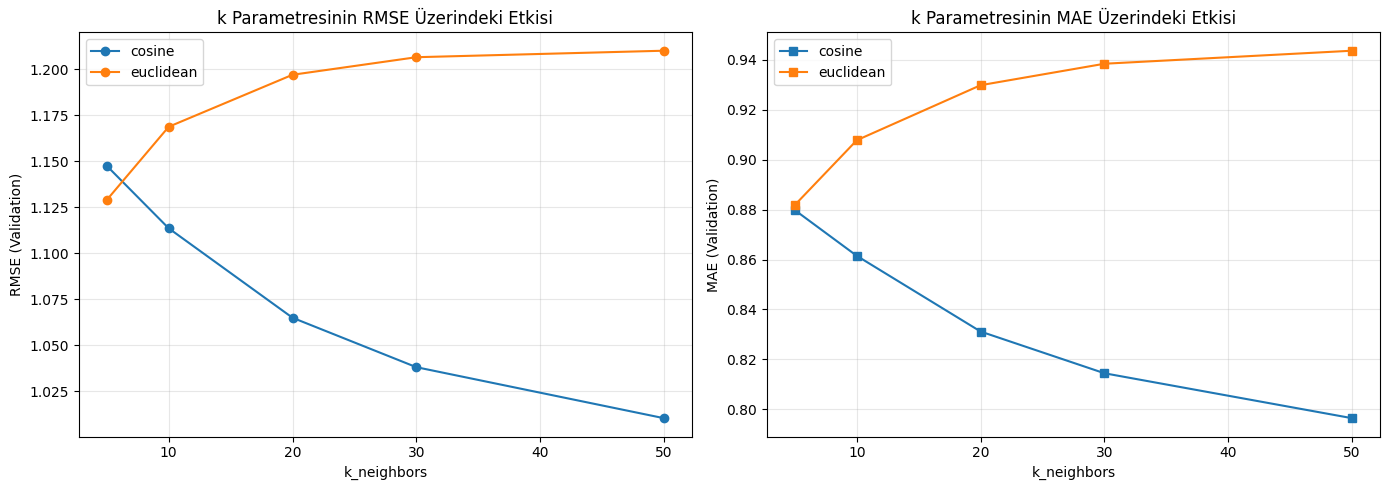


Parametre optimizasyonu tablosu:
 k    metric     rmse      mae  samples
 5    cosine 1.147453 0.879790   160473
10    cosine 1.113509 0.861472   160473
20    cosine 1.064895 0.831128   160473
30    cosine 1.038038 0.814409   160473
50    cosine 1.010312 0.796394   160473
 5 euclidean 1.128889 0.881878   160473
10 euclidean 1.168657 0.907818   160473
20 euclidean 1.196917 0.929879   160473
30 euclidean 1.206464 0.938481   160473
50 euclidean 1.209996 0.943702   160473


In [5]:
# Parametre etkisini görselleştir
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE'ye göre karşılaştırma
for metric in param_grid['metric']:
    metric_data = results_df[results_df['metric'] == metric].sort_values('k')
    axes[0].plot(metric_data['k'], metric_data['rmse'], marker='o', label=metric)

axes[0].set_xlabel('k_neighbors')
axes[0].set_ylabel('RMSE (Validation)')
axes[0].set_title('k Parametresinin RMSE Üzerindeki Etkisi')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE'ye göre karşılaştırma
for metric in param_grid['metric']:
    metric_data = results_df[results_df['metric'] == metric].sort_values('k')
    axes[1].plot(metric_data['k'], metric_data['mae'], marker='s', label=metric)

axes[1].set_xlabel('k_neighbors')
axes[1].set_ylabel('MAE (Validation)')
axes[1].set_title('k Parametresinin MAE Üzerindeki Etkisi')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print('\nParametre optimizasyonu tablosu:')
print(results_df.to_string(index=False))

In [6]:
# En iyi parametrelerle nihai modeli fit et ve test kümesi üzerinde değerlendir
best_k = int(best_params['k'])
best_metric = best_params['metric']

print(f'Nihai model fit ediliyor (k={best_k}, metric={best_metric})...')
knn_model = fit_knn_on_users(sparse_mat, n_neighbors=best_k, metric=best_metric)
print('Nihai KNN modeli fit edildi.')

Nihai model fit ediliyor (k=50, metric=cosine)...
Nihai KNN modeli fit edildi.


In [7]:
# Ön-hesaplanan komşular (nihai model ile)
distances_matrix, indices_matrix = knn_model.kneighbors(sparse_mat, n_neighbors=best_k)
piv_filled = piv.fillna(0)
piv_nan = piv.fillna(np.nan)
piv_filled_array = piv_filled.values
piv_nan_array = piv_nan.values
global_mean = np.nanmean(piv_nan_array) if piv_nan_array.size>0 else np.nan
print('Ön-hesaplanan komşular hazır (nihai parametreler ile).')

Ön-hesaplanan komşular hazır (nihai parametreler ile).


In [8]:
# 5: Test üzerinde tahmin ve değerlendirme (ön-hesaplanan komşular + optimal parametreler)
y_true = []
y_pred = []
missing = 0
cnt = 0
for _, row in test_r.iterrows():
    cnt += 1
    if cnt % 2000 == 0:
        print(f'İlerleme: {cnt} test örneği işlendi...')
    uid = row['userId']
    mid = row['movieId']
    true_r = row['rating']
    if uid not in user_ids or mid not in item_ids:
        missing += 1
        continue
    pred = predict_user_based_cached(uid, mid, piv_nan_array, indices_matrix, distances_matrix, user_ids, item_ids, k=best_k)
    if np.isnan(pred):
        if not np.isnan(global_mean):
            pred = global_mean
        else:
            missing += 1
            continue
    y_true.append(true_r)
    y_pred.append(pred)

print('Tahmin yapılamayan test örnekleri:', missing)
if len(y_true) > 0:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f'\n✓ Final Test Sonuçları (Optimizasyon sonrası):')
    print(f'  RMSE: {rmse:.4f}  MAE: {mae:.4f}')
    print(f'  Değerlendirme yapılan örnek sayısı: {len(y_true)}')
else:
    print('Değerlendirme için yeterli tahmin yok.')

İlerleme: 2000 test örneği işlendi...
İlerleme: 4000 test örneği işlendi...
İlerleme: 6000 test örneği işlendi...
İlerleme: 8000 test örneği işlendi...
İlerleme: 10000 test örneği işlendi...
İlerleme: 12000 test örneği işlendi...
İlerleme: 14000 test örneği işlendi...
İlerleme: 16000 test örneği işlendi...
İlerleme: 18000 test örneği işlendi...
İlerleme: 20000 test örneği işlendi...
İlerleme: 22000 test örneği işlendi...
İlerleme: 24000 test örneği işlendi...
İlerleme: 26000 test örneği işlendi...
İlerleme: 28000 test örneği işlendi...
İlerleme: 30000 test örneği işlendi...
İlerleme: 32000 test örneği işlendi...
İlerleme: 34000 test örneği işlendi...
İlerleme: 36000 test örneği işlendi...
İlerleme: 38000 test örneği işlendi...
İlerleme: 40000 test örneği işlendi...
İlerleme: 42000 test örneği işlendi...
İlerleme: 44000 test örneği işlendi...
İlerleme: 46000 test örneği işlendi...
İlerleme: 48000 test örneği işlendi...
İlerleme: 50000 test örneği işlendi...
İlerleme: 52000 test örneği i

Notlar / İpuçları:
- Eğer ratings.dat dosyası büyükse çalıştırma yavaş olabilir; sparse matris ve n_jobs parametresi kullanılmalı.
- k parametresi (k_neighbors) değiştirerek en iyi sonucu arayın; ayrıca ağırlıklandırmada similarity^p kullanmak gibi denemeler yapılabilir.
- Daha gelişmiş yöntemler için sklearn veya implicit/funkcionel matrix factorization yöntemlerine bakın.